In [33]:
# import packages
import pandas as pd

In [34]:
import pandas as pd
import numpy as np
from pathlib import Path

# --- load CBI REIBOR O/N (percent, daily) and convert to daily log rf ---
def load_cbi_rf_logdaily(path: Path, col_name: str = "REIBOR, O/N") -> pd.Series:
    df = pd.read_csv(path)
    # clean headers & parse dates (CBI uses dd.mm.yyyy)
    df.columns = [c.strip() for c in df.columns]
    df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")

    # percent -> decimal annual yield
    y_annual = pd.to_numeric(df[col_name], errors="coerce") / 100.0
    s = pd.Series(y_annual.values, index=df["Date"]).sort_index().dropna()

    # convert annual yield to daily simple return then to daily *log* return
    # (daily compounding assumption, 252 trading days)
    r_daily_simple = (1 + s)**(1/252) - 1
    rf_log_daily = np.log1p(r_daily_simple)

    # align to business days and forward-fill
    rf_log_daily = rf_log_daily.asfreq("B").bfill()
    rf_log_daily.name = "rf_log_daily"
    return rf_log_daily

# go one level up from "notebook/" to repo root, then into data/market_data/rf
rf_folder = Path("../data/market_data/rf")
market_rates_file = rf_folder / "Market rates.csv"

rf_log_daily = load_cbi_rf_logdaily(market_rates_file, col_name="REIBOR, O/N")
print(rf_log_daily.head())


Date
1998-06-10    0.000295
1998-06-11    0.000302
1998-06-12    0.000291
1998-06-15    0.000300
1998-06-16    0.000298
Freq: B, Name: rf_log_daily, dtype: float64


In [35]:
import os, io, json
from pathlib import Path
import pandas as pd
import numpy as np

# =========================
# -------- CONFIG ---------
# =========================
WINDOWS = (252, 756, 1260)  # 1Y, 3Y, 5Y
ANN = 252

# If you want a constant RF, set RF_ANNUAL (e.g., 0.075 for 7.5%) and leave RF_CSV/RF_COL as None.
# If you want to use the CSV risk-free series (recommended), set RF_CSV/RF_COL and set RF_ANNUAL=None.
RF_ANNUAL = None

# These defaults match your repo:
#   data/market_data/rf/Market rates.csv   with a column "REIBOR, O/N"
def _find_repo_root(start=Path.cwd()):
    for p in [start, *start.parents]:
        if (p / ".git").exists() or (p / "docs").exists():
            return p
    return start

REPO_ROOT = _find_repo_root()
DATA_ROOT = REPO_ROOT / "data" / "market_data"
MARKET_DIR = DATA_ROOT / "market"
RF_CSV = DATA_ROOT / "rf" / "Market rates.csv"
RF_COL = "REIBOR, O/N"   # adjust if your header differs exactly (watch spaces/case)

# Output locations
OUT_TABLE_CSV = Path("sharpe_heatmap_table.csv")       # saved next to the notebook
SITE_DATA_DIR = REPO_ROOT / "docs" / "data"            # for website JSON
SITE_DATA_DIR.mkdir(parents=True, exist_ok=True)

# =========================
# ------ UTIL FUNCS -------
# =========================
def to_daily_rf_returns_from_annual(rf_annual, ann=ANN):
    """Convert annualized yield to a constant daily simple return."""
    return (1 + rf_annual)**(1/ann) - 1

def to_daily_rf_returns_from_series(rf_df, rate_col, ann=252):
    """
    rf_df indexed by date; column 'rate_col' is in PERCENT (e.g., 7.5 for 7.5%).
    Returns business-day daily simple returns Series named 'rf_daily'.
    """
    rf = rf_df[[rate_col]].copy()
    rf.index = pd.to_datetime(rf.index, errors="coerce")
    rf = rf.dropna(subset=[rate_col])               # drop rows with missing rate
    rf = rf.sort_index()

    # --- handle duplicate dates (e.g., multiple rows per day from the export) ---
    # keep the last observation per day (or use .mean() if you prefer)
    if not rf.index.is_unique:
        rf = rf.groupby(level=0).last()

    # percent -> decimal annual yield
    rf_dec = rf[rate_col] / 100.0

    # convert each day's annual yield to a daily simple return
    rf_daily = (1 + rf_dec).pow(1/ann) - 1

    # fill to business days; resample tolerates prior duplicates (unlike asfreq)
    rf_daily = rf_daily.resample("B").ffill()

    rf_daily.name = "rf_daily"
    return rf_daily


def load_rf_daily_series():
    if RF_CSV and RF_COL and Path(RF_CSV).exists():
        # Try reading with index in first column; if not, fall back to parse 'Date' column heuristics
        try:
            rf_df = pd.read_csv(RF_CSV, index_col=0)
            # if index isn't datetime, try to coerce
            if not np.issubdtype(pd.Index(rf_df.index).dtype, np.datetime64):
                rf_df.index = pd.to_datetime(rf_df.index, errors="coerce")
        except Exception:
            rf_df = pd.read_csv(RF_CSV)
            # guess date column
            date_col = next((c for c in rf_df.columns if str(c).lower() in ("date", "dagsetning")), rf_df.columns[0])
            rf_df[date_col] = pd.to_datetime(rf_df[date_col], errors="coerce")
            rf_df = rf_df.dropna(subset=[date_col]).set_index(date_col)
        return to_daily_rf_returns_from_series(rf_df, RF_COL)
    elif RF_ANNUAL is not None:
        # constant daily RF (Series-like scalar)
        return pd.Series(to_daily_rf_returns_from_annual(RF_ANNUAL), index=pd.DatetimeIndex([], freq="B"), name="rf_daily")
    else:
        return None  # falls back to 0% if not provided

rf_daily_series = load_rf_daily_series()

def load_nasdaq_iceland_csv(path: Path):
    """
    Handles NASDAQ Iceland CSVs that sometimes include a "sep=;" header and thousand separators.
    Returns a DataFrame indexed by date with a 'close' column.
    """
    with open(path, "r", encoding="latin1") as f:
        first = f.readline().strip()
        rest = f.read()
    if first.lower().startswith("sep=") and len(first) == 5:
        sep = first[-1]; raw = rest
    else:
        sep = None; raw = first + "\n" + rest
    df = pd.read_csv(io.StringIO(raw), sep=sep, engine="python")
    df.columns = [c.strip() for c in df.columns]
    lc = {c: c.lower() for c in df.columns}
    df = df.rename(columns=lc)

    date_col = "date"
    close_candidates = ["closing price","close","closing","lokaverð","loka verð","loka verd"]
    close_col = next((c for c in df.columns if c in close_candidates), None)
    if date_col not in df.columns or close_col is None:
        raise KeyError(f"Missing Date/Close. Columns: {list(df.columns)}")

    s = (df[close_col].astype(str)
         .str.replace("\u00A0","",regex=False)
         .str.replace(" ","",regex=False)
         .str.replace(",","",regex=False))
    df["close"] = pd.to_numeric(s, errors="coerce")
    df["date"] = pd.to_datetime(df[date_col], errors="coerce")
    df = df.dropna(subset=["date","close"]).sort_values("date").set_index("date")[["close"]]
    return df

def log_returns(close):
    return np.log(close/close.shift(1)).dropna()

def sharpe_from_excess(excess, ann_factor=ANN):
    mu, sig = excess.mean(), excess.std()
    return (mu / (sig if sig else np.nan)) * np.sqrt(ann_factor)

def windowed_sharpe(log_ret, windows_days=WINDOWS, ann_factor=ANN):
    out = {}
    # Build the daily risk-free Series aligned to log_ret
    if rf_daily_series is not None and (not isinstance(rf_daily_series, float)):
        if isinstance(rf_daily_series, pd.Series) and (rf_daily_series.index.size > 0):
            rf_daily = rf_daily_series.reindex(log_ret.index, method="ffill").fillna(method="ffill")
            excess = log_ret - rf_daily
        else:
            # rf_daily_series is a scalar-like series (constant RF)
            excess = log_ret - float(rf_daily_series.iloc[0]) if hasattr(rf_daily_series, "iloc") and len(rf_daily_series) else log_ret
    elif RF_ANNUAL is not None:
        rf_d = to_daily_rf_returns_from_annual(RF_ANNUAL, ann_factor)
        excess = log_ret - rf_d
    else:
        excess = log_ret  # rf = 0

    for wd in windows_days:
        tail = excess.tail(wd)
        out[f"{wd//252}Y"] = np.nan if len(tail) < max(30, wd//10) else sharpe_from_excess(tail, ann_factor)
    return out

# =========================
# ------- MAIN RUN --------
# =========================
print("CWD:", os.getcwd())
print("Repo root:", REPO_ROOT)

# --- find market CSVs (tickers) ---
if not MARKET_DIR.exists():
    raise FileNotFoundError(f"Expected market data folder not found: {MARKET_DIR}")

market_csvs = list(MARKET_DIR.rglob("*.csv")) + list(MARKET_DIR.rglob("*.CSV"))
if not market_csvs:
    raise RuntimeError(f"No market CSVs found under {MARKET_DIR}")

print(f"Found {len(market_csvs)} market CSVs")
print("Examples:", [p.relative_to(MARKET_DIR) for p in market_csvs[:5]])

rows, errors = [], []
for csv_path in market_csvs:
    try:
        df = load_nasdaq_iceland_csv(csv_path)
        r = log_returns(df["close"])
        metrics = windowed_sharpe(r)
        metrics["ticker"] = csv_path.stem.upper()
        metrics["obs"] = int(len(r))
        metrics["cum_return"] = float(np.exp(r.sum()) - 1)
        rows.append(metrics)
    except Exception as e:
        errors.append((str(csv_path.relative_to(MARKET_DIR)), str(e)))

if errors:
    print("\nFiles with issues:")
    for name, msg in errors:
        print(f" - {name}: {msg}")

if not rows:
    raise RuntimeError("No valid market CSVs loaded. See errors above and fix column names/separators.")

sharpe_df = pd.DataFrame.from_records(rows)
if "ticker" not in sharpe_df.columns:
    raise KeyError("Ticker column missing after row build.")
sharpe_df = sharpe_df.set_index("ticker").sort_index()
print("\nColumns built:", sharpe_df.columns.tolist())
print("\nSharpe table (head):")
print(sharpe_df.head())

# Save small table
sharpe_df[["1Y","3Y","5Y"]].to_csv(OUT_TABLE_CSV)
print(f"\nSaved: {OUT_TABLE_CSV.resolve()}")



CWD: /Users/smh/Desktop/Website/sveinnmargeir.github.io/notebook
Repo root: /Users/smh/Desktop/Website/sveinnmargeir.github.io
Found 31 market CSVs
Examples: [PosixPath('kvika.csv'), PosixPath('alvo.csv'), PosixPath('amrq.csv'), PosixPath('nova.csv'), PosixPath('eim.csv')]

Files with issues:
 - sharpe_heatmap_table.csv: "Missing Date/Close. Columns: ['ticker', '1y', '3y', '5y']"
 - sharpe_composite_rank.csv: "Missing Date/Close. Columns: ['ticker', 'composite_rank', '1y', '3y', '5y', 'obs', 'cum_return']"

Columns built: ['1Y', '3Y', '5Y', 'obs', 'cum_return']

Sharpe table (head):
              1Y        3Y        5Y   obs  cum_return
ticker                                                
ALVO   -0.958468 -0.167566 -0.301407   788   -0.230480
AMRQ    0.048461  0.401749  0.401749   697    0.775591
ARION   0.851506 -0.378980  0.624276  1788    0.981982
BRIM   -1.944946 -1.350616  0.070756  2491    0.539457
EIK     0.957636 -0.491817  0.312331  2491    0.928571

Saved: /Users/smh/Deskto

/var/folders/7q/6lj2n2p91rd55drvkkr0bqq40000gn/T/ipykernel_12464/3209377337.py:137: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/var/folders/7q/6lj2n2p91rd55drvkkr0bqq40000gn/T/ipykernel_12464/3209377337.py:137: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/var/folders/7q/6lj2n2p91rd55drvkkr0bqq40000gn/T/ipykernel_12464/3209377337.py:137: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/var/folders/7q/6lj2n2p91rd55drvkkr0bqq40000gn/T/ipykernel_12464/3209377337.py:137: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/var/folders/7q/6lj2n2p91rd55drvkkr0bqq40000gn/T/ipykernel_12464/3209377337.py:137: FutureWarning:

Series.fillna with 'meth

In [36]:
import numpy as np
import plotly.io as pio
import plotly.express as px

hm = sharpe_df[['1Y','3Y','5Y']].astype(float)

# sort if you want
hm = hm.sort_values('3Y', ascending=False)

fig = px.imshow(
    hm.values,
    x=hm.columns, y=hm.index,
    color_continuous_scale="RdYlGn",
    zmin=np.nanmin(hm.values), 
    zmax=np.nanmax(hm.values),
    aspect="auto"
)

# center scale at 0 explicitly
fig.update_coloraxes(cmid=0)

# Add annotations inside cells
text = [[f"{v:.2f}" if np.isfinite(v) else "" for v in row] for row in hm.values]
fig.update_traces(text=text, texttemplate="%{text}", textfont=dict(size=11))

fig.update_layout(
    title="Iceland Equities — Sharpe (log returns, annualized)",
    xaxis_title="", yaxis_title="",
    coloraxis_colorbar=dict(title="Sharpe"),
    template="plotly_white",
    margin=dict(l=80, r=30, t=60, b=30),
    width=700, height=max(300, 24*len(hm))
)

# Hover
fig.update_traces(
    hovertemplate="<b>%{y}</b><br>%{x}: %{z:.2f}<extra></extra>"
)

fig.show()
pio.write_json(fig, "../docs/data/sharpe/fig_sharpe_window.json")


In [37]:
def pct_rank(col): return col.rank(pct=True)
ranks = hm.apply(pct_rank)                 # percentile within each column
composite = ranks.mean(axis=1).sort_values(ascending=False)
rank_table = (pd.DataFrame({
    'composite_rank': composite,
    '1Y': hm['1Y'], '3Y': hm['3Y'], '5Y': hm['5Y'],
    'obs': sharpe_df['obs'], 'cum_return': sharpe_df['cum_return']
}).sort_values('composite_rank', ascending=False))

rank_table.to_csv("sharpe_composite_rank.csv")
print(rank_table.head(10))
print("Saved -> sharpe_composite_rank.csv")


        composite_rank        1Y        3Y        5Y   obs  cum_return
ticker                                                                
KALD          0.942529  1.524699  0.124417  0.619460  1488    1.415842
FESTI         0.885057  1.408764  0.116534  0.523332  2491    6.068558
SIMINN        0.804598  1.232315  0.022828  0.404415  2453    2.724928
HEIMAR        0.793103  1.419601 -0.292565  0.463362  2491    1.311361
HAGA          0.781609  0.626659  0.219155  0.455343  2491    1.728443
OLGERD        0.770115 -0.155382  0.520871  0.546731   798    0.821822
ARION         0.747126  0.851506 -0.378980  0.624276  1788    0.981982
SJOVA         0.747126  0.489534 -0.063287  0.505524  2491    2.604938
REITIR        0.712644  0.822664 -0.157127  0.398122  2491    0.548798
AMRQ          0.689655  0.048461  0.401749  0.401749   697    0.775591
Saved -> sharpe_composite_rank.csv


In [38]:
import numpy as np
import pandas as pd
import plotly.express as px

# rank_table from your code (index=ticker), with columns:
# ['composite_rank','1Y','3Y','5Y','obs','cum_return']

tbl = rank_table.copy().reset_index().rename(columns={"index":"ticker"})

fig = px.bar(
    tbl.sort_values("composite_rank", ascending=True),   # plot bottom→top then flip
    x="composite_rank",
    y="ticker",
    color="composite_rank",
    color_continuous_scale="RdYlGn",   # green = better
    orientation="h",
    hover_data={
        "ticker": True,
        "composite_rank": ":.2f",
        "1Y": ":.2f",
        "3Y": ":.2f",
        "5Y": ":.2f",
        "obs": True,
        "cum_return": ":.2f"
    },
    labels={"composite_rank":"Composite Sharpe Percentile"},
    title="Iceland Equities — Composite Sharpe Leaderboard (1Y/3Y/5Y)"
)

# nicer formatting
fig.update_layout(
    template="plotly_white",
    xaxis=dict(range=[0, 1], tickformat=".0%"),
    coloraxis_colorbar=dict(title="Composite<br>Percentile"),
    margin=dict(l=110, r=40, t=70, b=40),
    height=max(420, 28*len(tbl))  # auto-height
)

# show % labels on bars (optional)
fig.update_traces(
    text=tbl.sort_values("composite_rank", ascending=True)["composite_rank"].map(lambda v: f"{v:.0%}"),
    textposition="outside",
    cliponaxis=False
)

fig.show()
pio.write_json(fig, "../docs/data/sharpe/fig_sharpe_ranked.json")

In [39]:
from pathlib import Path
import pandas as pd
import numpy as np

DATA_DIR = Path("../data/market_data/market")  # or your folder path with all CSVs

def load_nasdaq_iceland_csv(path):
    import io
    with open(path, "r", encoding="latin1") as f:
        first = f.readline().strip()
        rest = f.read()
    if first.lower().startswith("sep=") and len(first) == 5:
        sep = first[-1]; raw = rest
    else:
        sep = None; raw = first + "\n" + rest

    df = pd.read_csv(io.StringIO(raw), sep=sep, engine="python")
    df.columns = [c.strip() for c in df.columns]
    df = df.rename(columns={c:c.lower() for c in df.columns})
    date_col = "date"
    close_candidates = ["closing price","close","closing","lokaverð","loka verð","loka verd"]
    close_col = next((c for c in df.columns if c in close_candidates), None)
    s = (df[close_col].astype(str)
         .str.replace("\u00A0","",regex=False)
         .str.replace(" ","",regex=False)
         .str.replace(",","",regex=False))
    df["close"] = pd.to_numeric(s, errors="coerce")
    df["date"] = pd.to_datetime(df[date_col], errors="coerce")
    df = df.dropna(subset=["date","close"]).sort_values("date")
    return df.set_index("date")["close"]

# ---- Build a wide close-price DataFrame ----
closes = pd.DataFrame()
for csv_path in DATA_DIR.glob("*.csv"):
    try:
        series = load_nasdaq_iceland_csv(csv_path)
        closes[csv_path.stem.upper()] = series
    except Exception as e:
        print(f"Skipping {csv_path.name}: {e}")

print(closes.tail())


Skipping sharpe_heatmap_table.csv: None
Skipping sharpe_composite_rank.csv: None
            KVIKA    ALVO    AMRQ  NOVA    EIM   SYN  SJOVA   HAGA   EIK  \
date                                                                       
2025-08-15   17.9  1025.0  118.00  4.94  362.0  26.2   43.8  106.0  13.8   
2025-08-18   18.1  1080.0  116.00  4.92  362.0  26.2   43.8  108.0  13.8   
2025-08-19   17.9  1070.0  114.75  4.93  356.0  25.8   43.9  106.0  13.6   
2025-08-20   17.8  1025.0  114.00  4.92  353.0  25.6   43.8  105.0  13.6   
2025-08-21   17.9     NaN  112.75  4.88  355.0  25.6   43.8  106.0  13.5   

            HEIMAR  ...  BRIM  FESTI    ISF  KALD   OMXI15  ICEAIR     JBTM  \
date                ...                                                       
2025-08-15    36.8  ...  60.0  300.0  122.0  24.6  2634.21  1.0450  17000.0   
2025-08-18    36.8  ...  59.5  296.0  121.0  24.2  2642.65  1.0500  17000.0   
2025-08-19    36.4  ...  59.5  298.0  120.0  24.0  2630.44  1.0475  17

In [40]:
import numpy as np, pandas as pd
import plotly.express as px
import plotly.graph_objects as go

ann = 252
logret = np.log(closes / closes.shift(1))  # closes: wide price DF (date × tickers)

def risk_return(df, window_days):
    win = df.tail(window_days)
    valid = win.dropna(axis=1, thresh=int(0.8*len(win)))
    mu = valid.mean() * ann
    vol = valid.std() * np.sqrt(ann)
    sharpe = mu / vol
    rr = pd.DataFrame({
        "ticker": mu.index,
        "ann_ret": mu.values,
        "ann_vol": vol.values,
        "sharpe": sharpe.values
    })
    return rr.dropna()

data_1y = risk_return(logret, 252)
data_3y = risk_return(logret, 756)
data_5y = risk_return(logret, 1260)

fig = go.Figure()

for name, df in [("1Y", data_1y), ("3Y", data_3y), ("5Y", data_5y)]:
    fig.add_trace(go.Scatter(
        x=df["ann_vol"], y=df["ann_ret"], mode="markers+text",
        text=df["ticker"], textposition="top center", textfont=dict(size=10),
        marker=dict(
            size=9,
            line=dict(width=0.6, color="black"),
            color=df["sharpe"],
            colorscale="RdYlGn",
            colorbar=dict(title="Sharpe"),
            showscale=True
        ),
        name=name,
        hovertemplate="<b>%{text}</b><br>Vol: %{x:.2%}<br>Ret: %{y:.2%}<br>Sharpe: %{marker.color:.2f}<extra></extra>",
        visible=True if name == "1Y" else False
    ))

# Axes & layout (no boundaries, Plotly will auto-scale)
fig.update_layout(
    title="Iceland Equities — Risk vs Return (log returns) • Select horizon",
    xaxis_title="Annualized Volatility",
    yaxis_title="Annualized Return",
    template="plotly_white",
    hovermode="closest",
    width=850, height=600
)

# Dropdown to toggle horizon
fig.update_layout(
    updatemenus=[dict(
        type="dropdown", x=0.02, y=1.12,
        buttons=[
            dict(label="1Y", method="update",
                 args=[{"visible": [True, False, False]}]),
            dict(label="3Y", method="update",
                 args=[{"visible": [False, True, False]}]),
            dict(label="5Y", method="update",
                 args=[{"visible": [False, False, True]}]),
        ]
    )]
)

# Zero line
fig.add_hline(y=0, line_width=1, line_color="lightgray")

fig.show()
pio.write_json(fig, "../docs/data/sharpe/fig_sharpe_graphed_by_year.json")


In [41]:
import numpy as np, pandas as pd
import plotly.express as px
import plotly.graph_objects as go

ann = 252
logret = np.log(closes / closes.shift(1))  # closes: wide price DF (date × tickers)

def risk_return(df, window_days):
    win = df.tail(window_days)
    valid = win.dropna(axis=1, thresh=int(0.8*len(win)))
    mu = valid.mean() * ann
    vol = valid.std() * np.sqrt(ann)
    sharpe = mu / vol
    rr = pd.DataFrame({
        "ticker": mu.index,
        "ann_ret": mu.values,
        "ann_vol": vol.values,
        "sharpe": sharpe.values
    })
    return rr.dropna()

def plot_risk_return(rr: pd.DataFrame, title: str):
    fig = go.Figure(go.Scatter(
        x=rr["ann_vol"], y=rr["ann_ret"], mode="markers+text",
        text=rr["ticker"], textposition="top center", textfont=dict(size=10),
        marker=dict(
            size=9,
            line=dict(width=0.6, color="black"),
            color=rr["sharpe"],
            colorscale="RdYlGn",
            colorbar=dict(title="Sharpe"),
            showscale=True
        ),
        hovertemplate="<b>%{text}</b><br>Vol: %{x:.2%}<br>Ret: %{y:.2%}<br>Sharpe: %{marker.color:.2f}<extra></extra>",
        name=title
    ))
    fig.update_layout(
        title=title,
        xaxis_title="Annualized Volatility",
        yaxis_title="Annualized Return",
        template="plotly_white",
        hovermode="closest",
        width=850, height=600
    )
    fig.add_hline(y=0, line_width=1, line_color="lightgray")
    fig.show()
    return fig

# Build datasets
data_1y = risk_return(logret, 252)
data_3y = risk_return(logret, 756)
data_5y = risk_return(logret, 1260)

# Three separate figures
fig_1y = plot_risk_return(data_1y,  "Risk vs Return (1Y, log returns)")
fig_3y = plot_risk_return(data_3y,  "Risk vs Return (3Y, log returns)")
fig_5y = plot_risk_return(data_5y,  "Risk vs Return (5Y, log returns)")

# (Optional) save
# fig_1y.write_html("risk_return_1y.html");  fig_1y.write_image("risk_return_1y.png", scale=2)
# fig_3y.write_html("risk_return_3y.html");  fig_3y.write_image("risk_return_3y.png", scale=2)
# fig_5y.write_html("risk_return_5y.html");  fig_5y.write_image("risk_return_5y.png", scale=2)


/var/folders/7q/6lj2n2p91rd55drvkkr0bqq40000gn/T/ipykernel_12464/1178204738.py:25: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



   Lookback  Skip       Side   CAGR    Vol  Sharpe  MaxDD  HitRate   Obs
0         3     1   LongOnly  0.074  0.183   0.482 -0.297    0.529  85.0
2         6     1   LongOnly  0.141  0.173   0.850 -0.272    0.573  82.0
4        12     1   LongOnly  0.122  0.174   0.749 -0.252    0.579  76.0
1         3     1  LongShort -0.009  0.180   0.041 -0.451    0.506  85.0
3         6     1  LongShort  0.128  0.191   0.725 -0.198    0.549  82.0
5        12     1  LongShort  0.099  0.203   0.567 -0.356    0.553  76.0


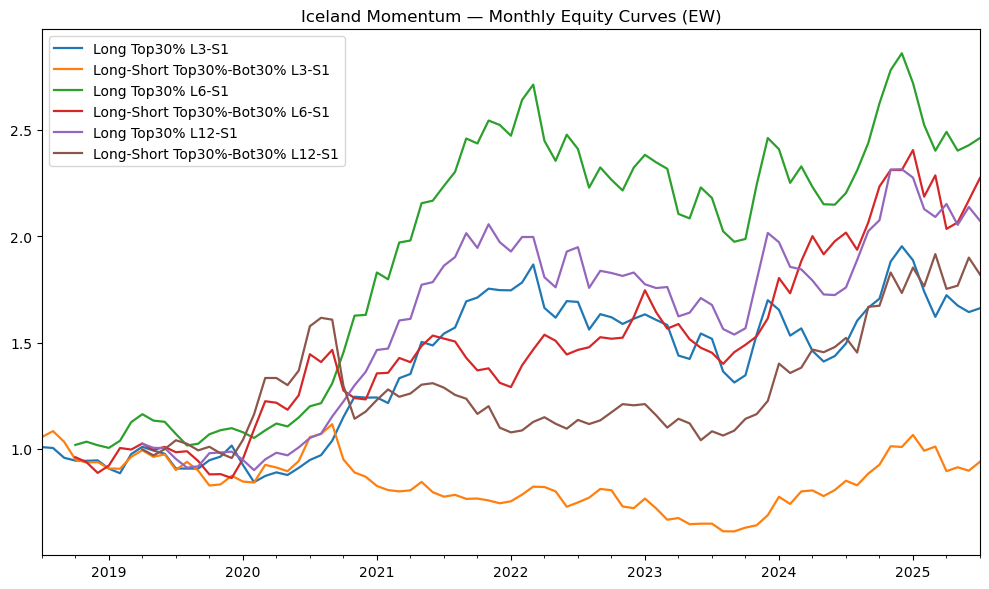

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------- Helpers --------
def perf_stats(r, ann=12):
    r = r.dropna()
    if len(r) == 0:
        return {"CAGR": np.nan, "Vol": np.nan, "Sharpe": np.nan, "MaxDD": np.nan, "HitRate": np.nan, "Obs": 0}
    cum = (1 + r).cumprod()
    cagr = cum.iloc[-1]**(ann/len(r)) - 1
    vol  = r.std() * np.sqrt(ann)
    sharpe = (r.mean() * ann) / vol if vol > 0 else np.nan
    roll_max = cum.cummax()
    dd = cum/roll_max - 1
    maxdd = dd.min()
    hit = (r > 0).mean()
    return {"CAGR": cagr, "Vol": vol, "Sharpe": sharpe, "MaxDD": maxdd, "HitRate": hit, "Obs": len(r)}

def equity_curve(r, label):
    (1+r.dropna()).cumprod().plot(lw=1.6, label=label)

# -------- Prep monthly prices/returns --------
# closes: daily prices (Date index), columns = tickers
prices_m = closes.resample('M').last()
rets_m   = prices_m.pct_change()  # next-month realized returns when shifted -1 in portfolio calc

# -------- Momentum backtest --------
def run_momentum(prices_m, lookback=12, skip=1, top_q=0.3, bot_q=0.3, min_names=5, long_short=True):
    """
    prices_m: month-end prices (Date × Ticker)
    lookback: L in L-1 momentum (e.g., 12 => use t-12..t-2 window effectively via skip=1)
    skip: months to skip (usually 1 => '12-1 momentum')
    long_short: if True, long top_q & short bottom_q; else long-only top_q
    """
    # momentum signal: price(t-skip) / price(t-skip-lookback) - 1
    mom = prices_m.shift(skip) / prices_m.shift(skip + lookback) - 1

    # forward next-month returns for P&L attribution
    fwd_ret = prices_m.pct_change().shift(-1)

    long_r, ls_r = [], []
    dates = []

    for dt in mom.index:
        s = mom.loc[dt].dropna()
        if s.count() < max(min_names, 3):
            continue

        # ranks (higher momentum is better)
        ranks = s.rank(method='first', ascending=False)
        n = len(ranks)
        k_long = max(int(np.floor(n*top_q)), 1)
        k_short = max(int(np.floor(n*bot_q)), 1) if long_short else 0

        long_names = ranks.nsmallest(k_long).index
        short_names = ranks.nlargest(k_short).index if long_short else []

        # next month's returns realized
        if dt not in fwd_ret.index:
            continue
        nxt = fwd_ret.loc[dt]

        # equal-weight portfolio returns
        r_long = nxt[long_names].mean(skipna=True)
        if long_short and k_short > 0:
            r_short = nxt[short_names].mean(skipna=True)
            r_ls = r_long - r_short
        else:
            r_ls = np.nan

        long_r.append(r_long)
        ls_r.append(r_ls)
        dates.append(dt)

    long_ser = pd.Series(long_r, index=pd.to_datetime(dates), name=f"Long_Top{int(top_q*100)}_L{lookback}-S{skip}")
    ls_ser   = pd.Series(ls_r,   index=pd.to_datetime(dates), name=f"LongShort_Top{int(top_q*100)}_Bot{int(bot_q*100)}_L{lookback}-S{skip}")

    return long_ser, ls_ser

# -------- Run a small grid and summarize --------
grid = [(3,1), (6,1), (12,1)]
results = {}

for L,S in grid:
    long_only, long_short = run_momentum(prices_m, lookback=L, skip=S, top_q=0.3, bot_q=0.3, long_short=True)
    results[(L,S,"LongOnly")]   = perf_stats(long_only, ann=12)
    results[(L,S,"LongShort")]  = perf_stats(long_short.dropna(), ann=12)

summary = (pd.DataFrame(results)
             .T.rename_axis(["Lookback","Skip","Side"])
             .reset_index()
             .sort_values(["Side","Lookback"]))
print(summary.round(3))

# -------- Plot equity curves --------
plt.figure(figsize=(10,6))
for (L,S) in grid:
    long_only, long_short = run_momentum(prices_m, lookback=L, skip=S, top_q=0.3, bot_q=0.3, long_short=True)
    equity_curve(long_only, f"Long Top30% L{L}-S{S}")
    equity_curve(long_short.dropna(), f"Long-Short Top30%-Bot30% L{L}-S{S}")
plt.title("Iceland Momentum — Monthly Equity Curves (EW)")
plt.legend()
plt.tight_layout()
plt.show()


correlation

/var/folders/7q/6lj2n2p91rd55drvkkr0bqq40000gn/T/ipykernel_12464/1451456753.py:1: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



    Ticker1 Ticker2      Corr
668  OMXI15    JBTM  0.723027
723    JBTM  OMXI15  0.723027
645  OMXI15    ALVO  0.675834
50     ALVO  OMXI15  0.675834
650  OMXI15   SJOVA  0.652416
190   SJOVA  OMXI15  0.652416
442   ARION  OMXI15  0.650781
659  OMXI15   ARION  0.650781
268  HEIMAR  REITIR  0.650753
485  REITIR  HEIMAR  0.650753
651  OMXI15    HAGA  0.617042
218    HAGA  OMXI15  0.617042
470     OCS  OMXI15  0.614163
660  OMXI15     OCS  0.614163
661  OMXI15  REITIR  0.592098
498  REITIR  OMXI15  0.592098
653  OMXI15  HEIMAR  0.590971
274  HEIMAR  OMXI15  0.590971
557    BRIM     SVN  0.590011
747     SVN    BRIM  0.590011


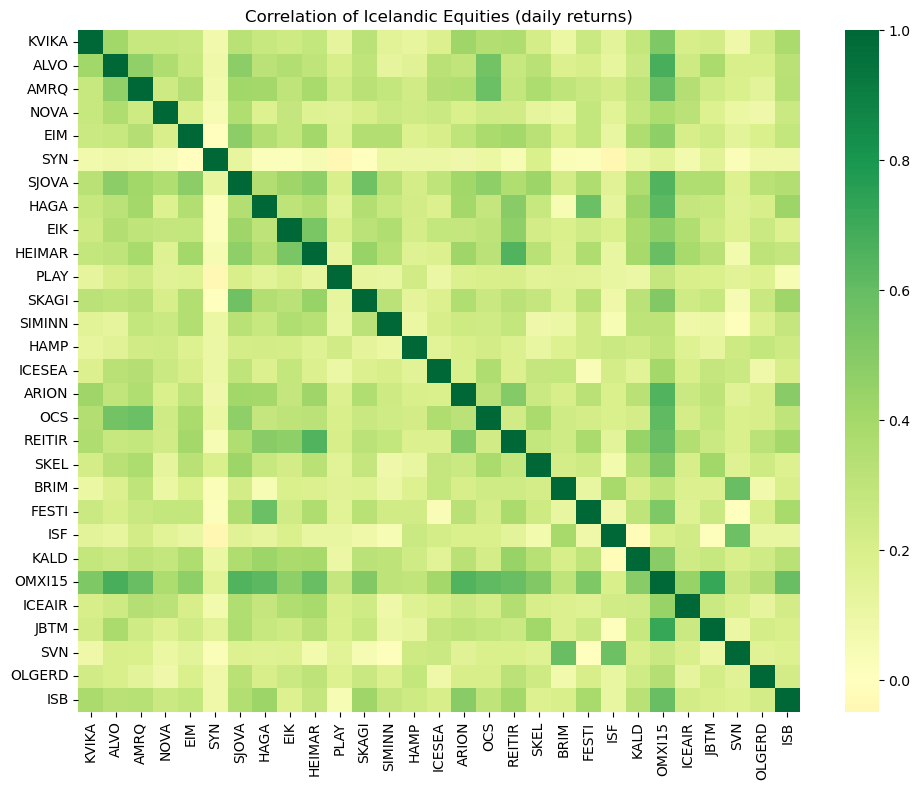

In [43]:
rets = closes.pct_change().dropna()   # or np.log(closes/closes.shift(1))
corr = rets.corr()
corr_pairs = (
    corr.where(~np.eye(corr.shape[0],dtype=bool))
        .stack()
        .reset_index()
)
corr_pairs.columns = ["Ticker1","Ticker2","Corr"]

high_corr = corr_pairs.sort_values("Corr", ascending=False)
print(high_corr.head(20))
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="RdYlGn", center=0, annot=False)
plt.title("Correlation of Icelandic Equities (daily returns)")
plt.tight_layout()
plt.show()


Cluster assignments:
SVN        1
ISF        1
BRIM       1
EIK        2
HEIMAR     2
REITIR     2
FESTI      3
SJOVA      3
HAGA       3
SKAGI      3
SIMINN     3
EIM        4
KVIKA      5
ARION      5
ISB        5
SKEL       6
OMXI15     6
JBTM       6
ICESEA     7
SYN        8
OCS        9
AMRQ       9
ALVO       9
PLAY      10
ICEAIR    10
NOVA      11
KALD      12
HAMP      13
OLGERD    14
Name: Cluster, dtype: int32


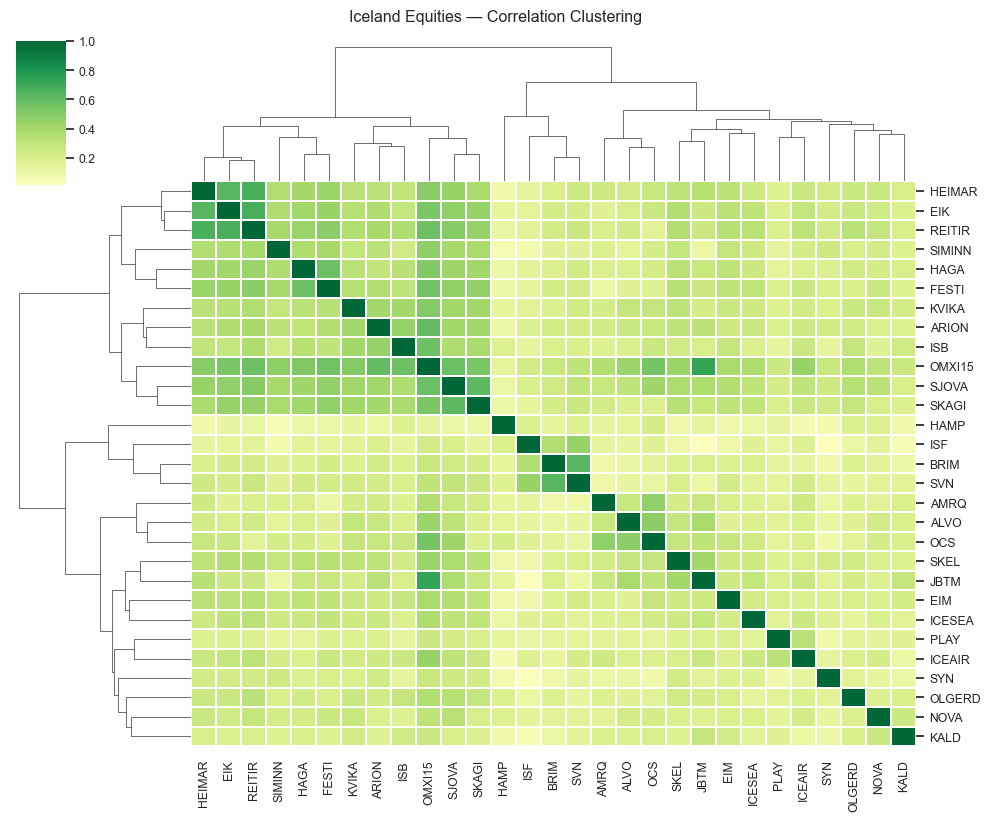

In [44]:
import numpy as np, pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

# logret: your daily log returns DataFrame (date × tickers)

# --- Compute correlation matrix ---
corr = logret.corr()

# --- Hierarchical clustering on correlation distance ---
# Convert correlation -> distance (so perfect correlation = 0)
dist = 1 - corr
# linkage matrix
link = linkage(squareform(dist, checks=False), method="ward")
# cluster labels (adjust t for granularity)
labels = fcluster(link, t=0.7, criterion="distance")

clusters = pd.Series(labels, index=corr.index, name="Cluster")

print("Cluster assignments:")
print(clusters.sort_values())

# --- Heatmap with clustering ---
sns.set(font_scale=0.8)
cg = sns.clustermap(
    corr,
    method="ward",
    cmap="RdYlGn",
    center=0,
    figsize=(10, 8),
    annot=False,  # turn on if you want numbers
    linewidths=0.2
)
plt.suptitle("Iceland Equities — Correlation Clustering", y=1.02)
plt.show()
